# Airbnb Popularity Predict

In the second part, we will illustrate the use of multiple linear regression for finding the effect of important factors affecting the sale of Airbnb hosting.
The data for the  is taken generously from Kaggle's [New York City Airbnb Open Data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).
For the second part, we will focus on the task of predicting the popularity of airbnb listing, which is indicated by the number of reviews from the dataset:

<img src="airbnb.png" height="300" width="300">


The factors we will be taking into considerations for the second part are: neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, availability_365.

In [127]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics.pairwise import pairwise_kernels
import scipy
from sklearn import svm, linear_model
from sklearn.model_selection import GridSearchCV
import time
import seaborn as sns

In [129]:
df = pd.read_csv('AB_NYC_2019.csv',
                na_values='?',header=None)
df.columns = df.iloc[0]
df = df[1:]
df = df.dropna()
df.head()

C:\Users\zzw_e\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,6,7,9,10,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
4,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
6,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.975,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# Preprocess Data

In [114]:
xnames = ['neighbourhood_group','latitude','longitude','room_type','price',
         'minimum_nights', 'calculated_host_listings_count','availability_365']
X = np.array(df[xnames])
ID = np.array(df['id'])
ID = ID.astype(int)
y = np.array(df['number_of_reviews'])
y = y.astype(int)
# Convert neighborhood to Brooklyn-0, Manhattan-1, Others-2
neighbourhood_group = X[:,0]
for i in range(len(neighbourhood_group)):
    if neighbourhood_group[i] == "Brooklyn":
        neighbourhood_group[i] = 0
    elif neighbourhood_group[i] == "Manhattan":
        neighbourhood_group[i] = 1
    else:
        neighbourhood_group[i] = 2

# Convert room_type: Private room-0, Entire home/apt-1
room_type = X[:,3]
PRI_VAL = "Private room"
ENT_VAL = "Entire home/apt"
for i in range(len(room_type)):
    if room_type[i] == PRI_VAL:
        room_type[i] = 0
    elif room_type[i] == ENT_VAL:
        room_type[i] = 1
    else:
        room_type[i] = 2
X[:,1] = X[:,1].astype(float)
X[:,2] = X[:,2].astype(float)
X[:,4] = X[:,4].astype(int)
X[:,5] = X[:,5].astype(int)
X[:,6] = X[:,6].astype(int)
X[:,7] = X[:,7].astype(int)
print("Converted Dataset X:\n",X)
print("\nwith dimension:\n", X.shape)
df["room_type"] = room_type
df["neighbourhood_group"] = neighbourhood_group

Converted Dataset X:
 [[0 40.64749 -73.97237 ... 1 6 365]
 [1 40.75362 -73.98377 ... 1 2 355]
 [0 40.68514 -73.95976 ... 1 1 194]
 ...
 [2 40.54179 -74.14275 ... 1 1 87]
 [2 40.80787 -73.92399999999999 ... 1 1 40]
 [0 40.69805 -73.92801 ... 1 1 1]]

with dimension:
 (38821, 8)


In [115]:
df["number_of_reviews"].describe()

count     38821
unique      500
top           1
freq       3066
Name: number_of_reviews, dtype: object

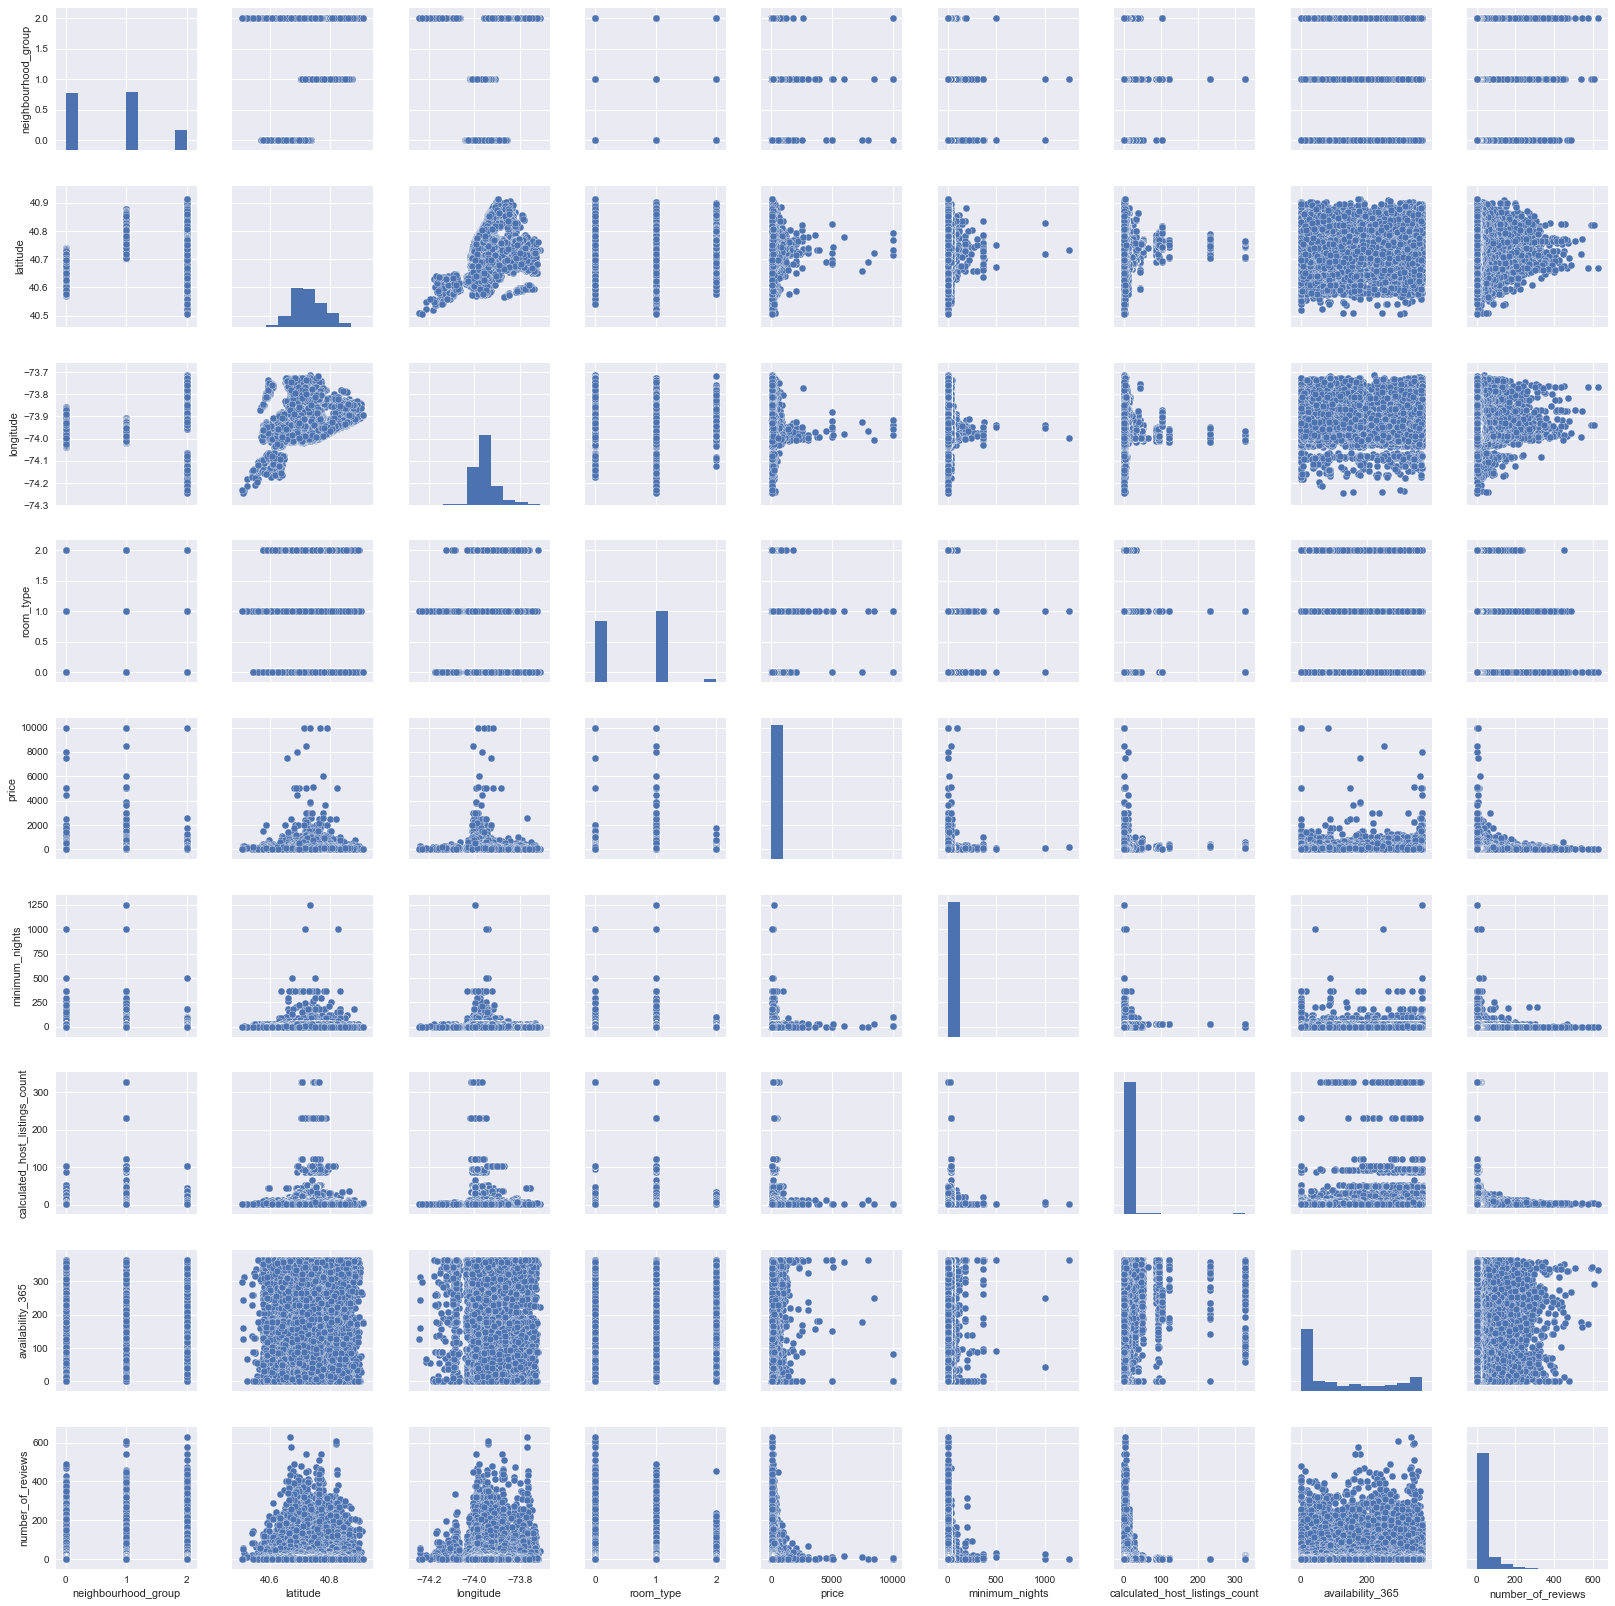

In [67]:
sns.set()
df['number_of_reviews'] = df['number_of_reviews'].astype(int)
df['price'] = df['price'].astype(int)
df["calculated_host_listings_count"] = df["calculated_host_listings_count"].astype(int)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['availability_365'] = df['availability_365'].astype(int)
input_lst = ['neighbourhood_group','latitude','longitude','room_type','price',
         'minimum_nights', 'calculated_host_listings_count','availability_365','number_of_reviews']
sns.pairplot(df[input_lst], size = 2.5)
plt.show();

# Split data into a training and test set with a ratio of 2/3 - 1/3

In [116]:
nt = len(X)
ind_lst = np.random.permutation(nt)

ntr = len(ind_lst) * 2//3
ntr_lst = ind_lst[:ntr]
nts = len(ind_lst) - ntr
nts_lst = ind_lst[ntr:]

IDtr = ID[ntr_lst]
IDts = ID[nts_lst]

Xtr = np.matrix(X[[ntr_lst]], dtype='int')
Xts1 = np.matrix(X[[nts_lst]], dtype='int')
ytr = y[ntr_lst]
yts1 = y[nts_lst]
print("X training set:\n",Xtr)
print("\nX testing set:\n",Xts1)
print("\ny training set:\n",ytr)
print("\ny testing set:\n",yts1)

X training set:
 [[  2  40 -73 ...  10   1 178]
 [  1  40 -74 ...   1   1   0]
 [  0  40 -73 ...   3   1   0]
 ...
 [  0  40 -73 ...   5   1   0]
 [  1  40 -73 ...  13   1  44]
 [  0  40 -73 ...   2   1   0]]

X testing set:
 [[  1  40 -73 ...   1   1 188]
 [  1  40 -73 ...   3  49 222]
 [  1  40 -73 ...   2   2   0]
 ...
 [  1  40 -73 ...   4  12 365]
 [  0  40 -73 ...   2   1  84]
 [  1  40 -73 ...   3   5 156]]

y training set:
 [ 3  7  6 ... 19  9  2]

y testing set:
 [13  1 23 ...  3 81 55]


# Fit a Multi-Linear Model

In [117]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """
    nsamp = len(X)
    ones = np.ones((nsamp,1))
    X_orig = X
    X = np.hstack((ones,X_orig))
    Xmat=np.matrix(X)
    ymat=np.matrix(y)
    ymat=np.transpose(ymat)
    Xmatt=np.transpose(Xmat)
    beta=np.linalg.inv(Xmatt*Xmat)*Xmatt*ymat
    return beta

In [118]:
beta_lst = fit_mult_linear(Xtr, ytr)
beta0 = beta_lst[0]
beta1 = beta_lst[1:]
print("beta_lst:\n",beta_lst)
print("beta0:\n",beta0)
print("beta1:\n",beta1)

beta_lst:
 [[ 2.42604622e+03]
 [-1.46208477e-01]
 [-4.78567958e+01]
 [ 3.67408500e+00]
 [-5.55084042e-01]
 [-1.08369481e-02]
 [-2.11214028e-01]
 [-1.59496217e-01]
 [ 8.24678866e-02]]
beta0:
 [[2426.04622222]]
beta1:
 [[-1.46208477e-01]
 [-4.78567958e+01]
 [ 3.67408500e+00]
 [-5.55084042e-01]
 [-1.08369481e-02]
 [-2.11214028e-01]
 [-1.59496217e-01]
 [ 8.24678866e-02]]


In [119]:
nsamp = len(Xtr)
ones = np.ones((nsamp,1))
X_orig = Xtr
X = np.hstack((ones,X_orig))
Xmat=np.matrix(X)
ymat=np.matrix(ytr)
ymat=np.transpose(ymat)

ytr_pred = Xmat*beta_lst
lossm = np.linalg.norm(np.array(ymat - ytr_pred))**2

print("multiple variable loss="+"{:.2e}".format(lossm))

multiple variable loss=1.30e+09


# Measure the Fit on the Testing Dataset

In [72]:
beta_ts = fit_mult_linear(Xts, yts)
beta0_ts = beta_ts[0]
beta1_ts = beta_ts[1:]
print("beta_test:\n",beta_ts)
print("beta0_test:\n",beta0_ts)
print("beta1_test:\n",beta1_ts)

beta_test:
 [[-3.51832593e+18]
 [ 2.69853833e+03]
 [ 2.61284314e+16]
 [-2.24408205e+02]
 [ 4.34989414e+02]
 [-1.59440847e-01]
 [-3.80997059e-01]
 [-3.22570207e-01]
 [-1.00852979e-01]]
beta0_test:
 [[-3.51832593e+18]]
beta1_test:
 [[ 2.69853833e+03]
 [ 2.61284314e+16]
 [-2.24408205e+02]
 [ 4.34989414e+02]
 [-1.59440847e-01]
 [-3.80997059e-01]
 [-3.22570207e-01]
 [-1.00852979e-01]]


In [74]:
nsamp_test = len(Xts)
ones_test = np.ones((nsamp_test,1))
X_orig_test = Xts
X_test = np.hstack((ones_test,X_orig_test))
Xmat_test=np.matrix(X_test)
ymat_test=np.matrix(yts)
ymat_test=np.transpose(ymat_test)

ytrain_pred_test = Xmat_test*beta_ts
lossm_test = np.linalg.norm(np.array(ymat_test - ytrain_pred_test))**2
print("multiple variable loss="+"{:.2e}".format(lossm_test))

multiple variable loss=7.92e+40


# Fit Data on Keras Model

In [76]:
df_tr = pd.read_csv('AB_NYC_2019.csv',
                na_values='?',header=None)
df_tr.columns = df_tr.iloc[0]
df_tr = df_tr[1:]
df_tr = df_tr.dropna()

C:\Users\zzw_e\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,6,7,9,10,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [80]:
inputs = ['neighbourhood_group','latitude','longitude','room_type','price',
         'minimum_nights', 'calculated_host_listings_count','availability_365']
Xtr = df[inputs]
scale = StandardScaler()
Xtr = scale.fit_transform(Xtr)
y = df['number_of_reviews'].values
seed = 7
np.random.seed(seed)
Xtr, Xts, ytr, yts = train_test_split(Xtr, y, test_size=0.33, random_state=seed)
print('Xtr:\n',Xtr)

Xtr:
 [[-1.0291431  -1.81540401  0.53453749 ... -0.10749563 -0.00633438
   1.93095823]
 [ 1.81009681  0.57957548  2.99789539 ... -0.22251218 -0.04435342
   1.53722182]
 [-1.0291431  -1.40733006 -0.20498388 ... -0.1650039  -0.15841052
  -0.88695918]
 ...
 [ 0.39047685  0.51465463 -0.84191889 ...  0.06502919 -0.15841052
   1.63758601]
 [-1.0291431  -0.79631023  0.95837554 ... -0.1650039  -0.15841052
   1.65302665]
 [-1.0291431  -1.99179962 -1.19829409 ... -0.1650039  -0.15841052
   1.35965443]]


In [81]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

C:\Users\zzw_e\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Create Keras Model

In [82]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=Xtr.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [83]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [84]:
hist = model.fit(Xtr, ytr, validation_data=(Xts,yts), epochs=150, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 26010 samples, validate on 12811 samples
Epoch 1/150
26010/26010 [==============================] - 1s 53us/step - loss: 2383.4255 - mean_absolute_error: 29.1460 - val_loss: 2091.3548 - val_mean_absolute_error: 29.5343
Epoch 2/150
26010/26010 [==============================] - 1s 53us/step - loss: 2162.2131 - mean_absolute_error: 28.7991 - val_loss: 2049.6519 - val_mean_absolute_error: 28.9210
Epoch 3/150
26010/26010 [==============================] - 1s 52us/step - loss: 2114.0240 - mean_absolute_error: 28.1882 - val_loss: 2005.0648 - val_mean_absolute_error: 27.3951
Epoch 4/150
26010/26010 [==============================] - 2s 63us/step - loss: 2072.9196 - mean_absolute_error: 27.8325 - val_loss: 1977.9023 - val_mean_absolute_error: 27.2477
Epoch 5/150
26010/26010 [==============================] - 2s 88us/step - loss: 2048.3630 - mean_absolute_error: 27.6465 - val_loss: 1968.6109 - val_mean_absolute_error: 28.3867
Epoch 6/150


26010/26010 [==============================] - 1s 40us/step - loss: 1922.8803 - mean_absolute_error: 26.3995 - val_loss: 1866.6109 - val_mean_absolute_error: 26.7820
Epoch 46/150
26010/26010 [==============================] - 1s 40us/step - loss: 1920.7016 - mean_absolute_error: 26.3395 - val_loss: 1855.2338 - val_mean_absolute_error: 25.8136
Epoch 47/150
26010/26010 [==============================] - 1s 41us/step - loss: 1922.2676 - mean_absolute_error: 26.3799 - val_loss: 1857.4387 - val_mean_absolute_error: 26.5634
Epoch 48/150
26010/26010 [==============================] - 1s 47us/step - loss: 1918.5977 - mean_absolute_error: 26.3410 - val_loss: 1855.8147 - val_mean_absolute_error: 26.0742
Epoch 49/150
26010/26010 [==============================] - 1s 44us/step - loss: 1914.2568 - mean_absolute_error: 26.2888 - val_loss: 1851.1106 - val_mean_absolute_error: 26.2944
Epoch 50/150
26010/26010 [==============================] - 1s 49us/step - loss: 1915.1170 - mean_absolute_error: 26.2

Epoch 91/150
26010/26010 [==============================] - 1s 50us/step - loss: 1885.0385 - mean_absolute_error: 25.9872 - val_loss: 1858.6566 - val_mean_absolute_error: 27.0550
Epoch 92/150
26010/26010 [==============================] - 1s 46us/step - loss: 1885.6883 - mean_absolute_error: 26.0171 - val_loss: 1842.2709 - val_mean_absolute_error: 25.8783
Epoch 93/150
26010/26010 [==============================] - 1s 47us/step - loss: 1883.2650 - mean_absolute_error: 26.0047 - val_loss: 1849.3609 - val_mean_absolute_error: 26.5431
Epoch 94/150
26010/26010 [==============================] - 1s 46us/step - loss: 1882.2481 - mean_absolute_error: 26.0467 - val_loss: 1846.2533 - val_mean_absolute_error: 25.9286
Epoch 95/150
26010/26010 [==============================] - 1s 49us/step - loss: 1882.0229 - mean_absolute_error: 25.9636 - val_loss: 1837.3747 - val_mean_absolute_error: 25.9120
Epoch 96/150
26010/26010 [==============================] - 1s 47us/step - loss: 1884.1356 - mean_absolut

26010/26010 [==============================] - 2s 58us/step - loss: 1864.7156 - mean_absolute_error: 25.8466 - val_loss: 1835.7042 - val_mean_absolute_error: 25.7583
Epoch 137/150
26010/26010 [==============================] - 2s 69us/step - loss: 1865.5245 - mean_absolute_error: 25.8296 - val_loss: 1832.0342 - val_mean_absolute_error: 25.1938
Epoch 138/150
26010/26010 [==============================] - 2s 72us/step - loss: 1864.8012 - mean_absolute_error: 25.8648 - val_loss: 1830.3782 - val_mean_absolute_error: 25.2162
Epoch 139/150
26010/26010 [==============================] - 2s 73us/step - loss: 1864.5986 - mean_absolute_error: 25.8456 - val_loss: 1834.3779 - val_mean_absolute_error: 25.0928
Epoch 140/150
26010/26010 [==============================] - 2s 76us/step - loss: 1864.3600 - mean_absolute_error: 25.8132 - val_loss: 1845.2370 - val_mean_absolute_error: 27.2037
Epoch 141/150
26010/26010 [==============================] - 2s 61us/step - loss: 1864.7898 - mean_absolute_error:

## Evaluation Model Performence

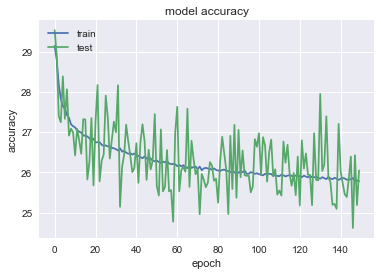

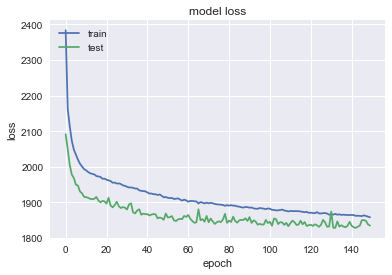

In [87]:
# Accuracy summary of Keras Model
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss summary of Keras Model
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Make Prediction on Testing Set

In [125]:
prediction = model.predict(Xts)
Xts_new = scale.inverse_transform(Xts)
result = {}
for i in range(len(inputs)):
    result[inputs[i]] = Xts_new[:,i]
result['number_of_reviews'] = prediction[:,0]

In [126]:
pd.DataFrame(result)

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews
0,0.0,40.63581,-73.96977,0.0,40.0,2.0,1.0,6.0,12.737062
1,0.0,40.67809,-73.95903,0.0,62.0,4.0,1.0,0.0,10.558903
2,1.0,40.75649,-73.97126,1.0,160.0,4.0,1.0,0.0,10.778886
3,1.0,40.75229,-73.99550,1.0,250.0,2.0,1.0,0.0,12.955484
4,0.0,40.58198,-73.95770,0.0,35.0,1.0,5.0,186.0,23.927732
5,1.0,40.75417,-73.96557,1.0,737.0,3.0,49.0,188.0,1.895184
6,0.0,40.65129,-73.94058,0.0,90.0,1.0,1.0,365.0,24.753946
7,0.0,40.68382,-73.95566,1.0,300.0,2.0,1.0,0.0,11.325005
8,0.0,40.69182,-73.92859,0.0,52.0,2.0,8.0,268.0,72.343987
9,1.0,40.74915,-73.97610,1.0,220.0,30.0,1.0,310.0,18.498091
